# Flight segments from Twin-Otter flights

Things to ask Alan about:

- [ ] for the altitude it looks like the GPS based altitude is nonsensical near the surface. I think lower down I should use the radar measurement, but it isn't obvious to me how to choose between the two. There is a discrepancy between the two: 1) radar seems to be scaled by x/2 of the GPS altitude, and there's an offset

In [1]:
%load_ext lab_black

In [2]:
from intake import open_catalog
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import yaml
import xarray as xr
import seaborn.objects as so
import pandas as pd
import seaborn as sns

import re

In [3]:
TO_CAT_URL = "https://raw.githubusercontent.com/leifdenby/eurec4a-intake/twinotter-masin/catalog.yml"

In [4]:
_cache = {}


def get_navdata_TO(flight_id):
    """
    :param nav_data: flight id
    """

    match = re.match("TO-(\d+)", flight_id)
    if match is None:
        raise Exception(f"Malformed flight id {flight_id}")
    flight_number = int(match.groups()[0])

    catalog = open_catalog(TO_CAT_URL)

    if flight_number not in _cache:
        ds = catalog.TO.MASIN[f"TO{flight_number}_1Hz"].to_dask()
        ds = ds.rename(dict(Time="time"))
        _cache[flight_number] = ds
    else:
        ds = _cache[flight_number]

    return xr.Dataset(
        {
            "time": ds.time,
            "lat": ds.LAT_OXTS,
            "lon": ds.LON_OXTS,
            "alt": ds.ALT_COMPOSITE,
            "roll": ds.ROLL_OXTS,
            "pitch": ds.PTCH_OXTS,
            "heading": ds.HDG_OXTS,
        }
    )

# Number of "level" legs

<img src='ATR-segments-dist.png' width=500 />

In [5]:
segment_labels = dict(
    # profile=["profile"],
    boundary_layer=["level", "boundary_layer"],
    cloud=["level", "cloud"],
    cloud_base=["level", "cloud_base"],
    ferry=["level", "transit"],
    flyby_bco=["level", "bco_flyby"],
    cloud_detrainment=["sawtooth", "cloud", "detrainment_layer"],
    # undef_level=["level"],
    coldpool=["level", "cold_pool"],
    above_cloud=["level", "above_cloud"],
    sawtooth=["sawtooth"],
)


def extract_segments(segments_fp):
    flightinfo = yaml.load(
        open(segments_fp),
        Loader=yaml.FullLoader,
    )
    ds_masin = get_navdata_TO(flight_id=flightinfo["flight_id"])
    segment_datasets = []
    for segment in flightinfo["segments"]:
        found_match = False
        for segment_name, segment_kinds in segment_labels.items():
            if set(segment_kinds) == set(segment["kinds"]):
                found_match = True
                ds_masin_segment = ds_masin.sel(
                    time=slice(segment["start"], segment["end"])
                )
                da_segment_alt = ds_masin_segment.alt.mean()
                ds_segment = xr.Dataset(
                    dict(
                        alt=da_segment_alt,
                        name=segment_name.replace("_", " "),
                        flight_id=flightinfo["flight_id"],
                        start=segment["start"],
                        end=segment["end"],
                    ),
                )
                segment_datasets.append(ds_segment)
        if not found_match and segment["kinds"] != ["profile"]:
            print(f"ignoring segment with kinds {segment['kinds']}")

    if len(segment_datasets) == 0:
        raise Exception(f"No matching segments for file {segments_fp}")

    ds_segments = xr.concat(segment_datasets, dim="segment_num")
    return ds_segments

In [6]:
segments_datasets = []
# skip the first flight since it was a calibration flight
segments_fps = sorted(
    list(Path("flight-phase-separation/flight_phase_files/TO/").glob("*.yaml"))
)[1:]

for segments_fp in tqdm(segments_fps):
    ds_segments = extract_segments(segments_fp=segments_fp)
    segments_datasets.append(ds_segments)

  0%|          | 0/24 [00:00<?, ?it/s]

ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level']
ignoring segment with kinds ['level', 'transit', 'cloud']
ignoring segment with kinds ['calibration', 'level']
ignoring segment with kinds ['calibration', 'level']
ignoring segment with kinds ['calibration', 'level']
ignoring segment with kinds ['level', 'transit', 'cloud']
ignoring segment with kinds ['level', 'boundary layer']
ignoring segment with k

In [7]:
ds_segments = xr.concat(segments_datasets, dim="segment_num").sortby("name")
ds_segments

<xarray.Dataset>
Dimensions:    (segment_num: 234)
Dimensions without coordinates: segment_num
Data variables:
    alt        (segment_num) float32 2.104e+03 2.9e+03 ... 3.01e+03 2.332e+03
    name       (segment_num) <U17 'above cloud' 'above cloud' ... 'sawtooth'
    flight_id  (segment_num) <U7 'TO-0336' 'TO-0340' ... 'TO-0347' 'TO-0351'
    start      (segment_num) datetime64[ns] 2020-01-30T13:23:07 ... 2020-02-1...
    end        (segment_num) datetime64[ns] 2020-01-30T13:28:10 ... 2020-02-1...

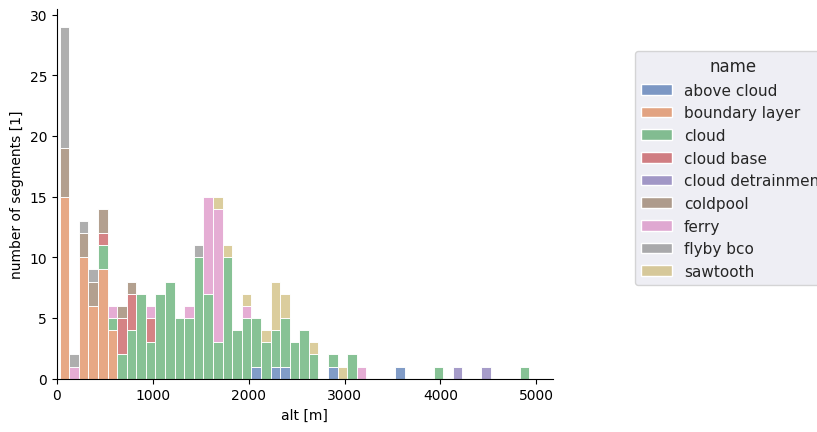

In [8]:
fig, ax = plt.subplots()

(
    so.Plot(ds_segments, x="alt", color="name")
    # .add(so.Bar(), so.Hist(binwidth=500), so.Dodge())
    .add(
        so.Bars(),
        so.Hist(binwidth=100),
        so.Stack()
        # so.Hist(binwidth=500),
    )
    .on(ax)
    .plot()
)
sns.despine(ax=ax)
ax.set_xlabel("alt [m]")
ax.set_ylabel("number of segments [1]")
ax.set_xlim(0, None)
fig.savefig("TO_flight_segment_counts.png", bbox_inches="tight")

# Flights summary table

<img src="ATR-flights-table.png" width=800 />

In [9]:
flight_numbers = range(330, 354)
flight_stats = dict()
for flight_num in tqdm(flight_numbers):
    flight_id = f"TO-{flight_num:04d}"  # segments use TO-0331 as flight id
    ds_masin = get_navdata_TO(flight_id=flight_id)
    flight_stats[flight_id] = dict(
        date=ds_masin.time.dt.strftime("%d/%m").isel(time=0).item(),
        takeoff=ds_masin.time.dt.strftime("%H:%M").isel(time=0).item(),
        landing=ds_masin.time.dt.strftime("%H:%M").isel(time=-1).item(),
    )

column_units = dict(
    date="Date [DD/MM]",
    takeoff="Takeoff [UTC]",
    landing="Landing [UTC]",
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [10]:
df_flight_stats = pd.DataFrame(flight_stats).transpose()
df_flight_stats.rename(columns=column_units).head()

,Date [DD/MM],Takeoff [UTC],Landing [UTC]
TO-0330,24/01,11:06,14:02
TO-0331,24/01,16:10,19:29
TO-0332,26/01,11:44,15:37
TO-0333,26/01,17:30,20:16
TO-0334,28/01,13:25,17:13


In [11]:
df_segments = ds_segments.to_dataframe()
df_bco_flybys = (
    df_segments[df_segments.name == "flyby bco"]
    .set_index("flight_id")["alt"]
    .rename("BCO flyby")
)
# df_flight_stats = df_flight_stats.join(df_bco_flybys)
# df_flight_stats["BCO flyby"] = df_flight_stats["BCO flyby"].apply(
#    lambda v: np.isnan(v) and " " or f"{v:.0f}m"
# )

In [12]:
def join_alts(df_segments_group):
    return ", ".join(f"{v:.0f}" for v in sorted(df_segments_group.alt)) + " m"


def add_segment_type_summary(
    df_flight_stats, df_segments, segment_name="boundary layer"
):
    df_flight_stats[f"{segment_name}"] = (
        df_segments[df_segments.name == segment_name]
        .groupby("flight_id")
        .apply(join_alts)
    )

    def isnan(v):
        try:
            return np.isnan(v)
        except:
            return False

    df_flight_stats[f"{segment_name}"] = df_flight_stats[f"{segment_name}"].apply(
        lambda v: isnan(v) and " " or v
    )


for segment_name in [
    "ferry",
    "boundary layer",
    "coldpool",
    "cloud base",
    "cloud",
    "flyby bco",
]:
    add_segment_type_summary(
        df_flight_stats=df_flight_stats,
        df_segments=df_segments,
        segment_name=segment_name,
    )

In [13]:
df_flight_stats.rename(columns=column_units)

,Date [DD/MM],Takeoff [UTC],Landing [UTC],ferry,boundary layer,coldpool,cloud base,cloud,flyby bco
TO-0330,24/01,11:06,14:02,,,,,,
TO-0331,24/01,16:10,19:29,1628 m,,,,"499, 505, 819, 1486, 1539, 1609, 2598, 3939, 4...",49 m
TO-0332,26/01,11:44,15:37,1621 m,"28, 29, 29, 30, 547, 547 m",,985 m,,327 m
TO-0333,26/01,17:30,20:16,1605 m,"29, 30, 514, 514 m",,,"989, 1150, 1602, 2138 m",
TO-0334,28/01,13:25,17:13,"952, 1626 m","339, 341 m",,691 m,"1023, 1509, 1765, 1841, 1930 m",37 m
TO-0335,28/01,18:22,22:03,3201 m,,,,"1455, 1759, 1929, 2247 m",
TO-0336,30/01,10:45,14:26,1634 m,"330, 375, 380 m",,,"748, 1049, 1142 m",403 m
TO-0337,31/01,13:19,16:55,"1354, 1655 m","305, 306 m",,658 m,"951, 1157, 1733, 1864, 1991 m",1501 m
TO-0338,31/01,18:24,22:30,,,,,,
TO-0339,02/02,11:50,15:31,"1612, 1630 m",313 m,,978 m,"1127, 1438, 1906, 2073, 2562, 2651, 3046 m",34 m


In [14]:
df_flight_stats.rename(columns=column_units).to_latex("TO_flight_segments_table.tex")